In [570]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

# **Question 4**
## **Part 3**

#### **Step 1: Data Loading and Preprocessing**

In [571]:
df = pd.read_csv("./SMSSpamCollection", sep="\t", header=None, names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [572]:
df['message'] = df['message'].str.lower()
df.head()

,label,message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [573]:
df['message'] = df['message'].str.replace(r'[^a-z0-9\s]', '', regex=True)
df['message'] = df['message'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['tokens'] = df['message'].str.split()
df.head()

,label,message,tokens
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [574]:
train_df, test_df = train_test_split(df,test_size=0.2,stratify=df['label'],random_state=42)

print("Training set class distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Training set class distribution:
label
ham     0.865829
spam    0.134171
Name: proportion, dtype: float64

Test set class distribution:
label
ham     0.866368
spam    0.133632
Name: proportion, dtype: float64


#### **Step 2: Implement Maximum Likelihood Estimator (MLE)**

In [575]:
spam_words = [word for tokens in train_df[train_df['label'] == 'spam']['tokens'] for word in tokens]
ham_words  = [word for tokens in train_df[train_df['label'] == 'ham']['tokens'] for word in tokens]

# Count frequency of each word
spam_counts = Counter(spam_words)
ham_counts  = Counter(ham_words)

total_spam_words = sum(spam_counts.values())
total_ham_words  = sum(ham_counts.values())

print("Total spam words:", total_spam_words)
print("Total ham words:", total_ham_words)

Total spam words: 14155
Total ham words: 53582


In [576]:
vocab = set(spam_counts.keys()).union(set(ham_counts.keys()))
V = len(vocab)

# Compute conditional probabilities
spam_word_probs = {word: spam_counts[word] / total_spam_words for word in spam_counts}
ham_word_probs  = {word: ham_counts[word] / total_ham_words for word in ham_counts}


In [577]:
# Prior probabilities
p_spam = len(train_df[train_df['label'] == 'spam']) / len(train_df)
p_ham  = len(train_df[train_df['label'] == 'ham']) / len(train_df)

In [578]:
def classify_message(message, spam_word_probs, ham_word_probs, p_spam, p_ham, V):
    # Tokenize and clean the input message
    tokens = message.lower().split()
    
    # Initialize log-probabilities with priors
    log_spam_prob = math.log(p_spam)
    log_ham_prob  = math.log(p_ham)
    
    # For each word in the message, add log probabilities
    for word in tokens:
        
        log_spam_prob += math.log(spam_word_probs.get(word, 1 / (sum(spam_word_probs.values()) * V)))
        log_ham_prob  += math.log(ham_word_probs.get(word, 1 / (sum(ham_word_probs.values()) * V)))
    
    # Compare which is larger
    if log_spam_prob > log_ham_prob:
        return "spam"
    else:
        return "ham"

In [579]:
test_df['predicted_MLE'] = test_df['message'].apply(
    lambda msg: classify_message(msg, spam_word_probs, ham_word_probs, p_spam, p_ham, V)
)

test_df.head()

,label,message,tokens,predicted_MLE
2825,ham,no need to buy lunch for me i eat maggi mee,"[no, need, to, buy, lunch, for, me, i, eat, ma...",ham
3695,ham,ok im not sure what time i finish tomorrow but...,"[ok, im, not, sure, what, time, i, finish, tom...",ham
3904,ham,waiting in e car 4 my mum lor u leh reach home...,"[waiting, in, e, car, 4, my, mum, lor, u, leh,...",ham
576,spam,you have won 1000 cash or a 2000 prize to clai...,"[you, have, won, 1000, cash, or, a, 2000, priz...",spam
2899,ham,if you r home then come down within 5 min,"[if, you, r, home, then, come, down, within, 5...",ham


In [580]:
accuracy_mle = accuracy_score(test_df['label'], test_df['predicted_MLE'])
precision_mle = precision_score(test_df['label'], test_df['predicted_MLE'], pos_label='spam')
recall_mle = recall_score(test_df['label'], test_df['predicted_MLE'], pos_label='spam')
f1_mle = f1_score(test_df['label'], test_df['predicted_MLE'], pos_label='spam')

# Display results
print(f"Accuracy:  {accuracy_mle:.4f}")
print(f"Precision: {precision_mle:.4f}")
print(f"Recall:    {recall_mle:.4f}")
print(f"F1 Score:  {f1_mle:.4f}")

Accuracy:  0.9578
Precision: 0.8036
Recall:    0.9060
F1 Score:  0.8517


#### **Step 3: Implement Maximum A Posteriori (MAP)**

In [581]:
spam_word_probs = {word: (spam_counts.get(word, 0) + 1) / (total_spam_words + V) for word in vocab}
ham_word_probs  = {word: (ham_counts.get(word, 0) + 1) / (total_ham_words + V) for word in vocab}

In [582]:
def classify_message_map(message, spam_counts, ham_counts, total_spam_words, total_ham_words, p_spam, p_ham, vocab, alpha):
    tokens = message.lower().split()
    V = len(vocab)  
    
    log_spam_prob = math.log(p_spam)
    log_ham_prob  = math.log(p_ham)
    
    for word in tokens:
        spam_prob = (spam_counts.get(word, 0) + alpha) / (total_spam_words + alpha * V)
        ham_prob  = (ham_counts.get(word, 0) + alpha) / (total_ham_words + alpha * V)
        
        log_spam_prob += math.log(spam_prob)
        log_ham_prob  += math.log(ham_prob)
    
    if log_spam_prob > log_ham_prob:
        return "spam"
    else:
        return "ham"

In [583]:
test_df['predicted_MAP'] = test_df['message'].apply(
    lambda msg: classify_message_map(msg, spam_counts, ham_counts, total_spam_words, total_ham_words, p_spam, p_ham, vocab, alpha=1)
)

test_df.head()

,label,message,tokens,predicted_MLE,predicted_MAP
2825,ham,no need to buy lunch for me i eat maggi mee,"[no, need, to, buy, lunch, for, me, i, eat, ma...",ham,ham
3695,ham,ok im not sure what time i finish tomorrow but...,"[ok, im, not, sure, what, time, i, finish, tom...",ham,ham
3904,ham,waiting in e car 4 my mum lor u leh reach home...,"[waiting, in, e, car, 4, my, mum, lor, u, leh,...",ham,ham
576,spam,you have won 1000 cash or a 2000 prize to clai...,"[you, have, won, 1000, cash, or, a, 2000, priz...",spam,spam
2899,ham,if you r home then come down within 5 min,"[if, you, r, home, then, come, down, within, 5...",ham,ham


In [584]:
# Performance metrics for MAP classifier
accuracy_map = accuracy_score(test_df['label'], test_df['predicted_MAP'])
precision_map = precision_score(test_df['label'], test_df['predicted_MAP'], pos_label='spam')
recall_map = recall_score(test_df['label'], test_df['predicted_MAP'], pos_label='spam')
f1_map = f1_score(test_df['label'], test_df['predicted_MAP'], pos_label='spam')

# Display results
print(f"Accuracy:  {accuracy_map:.4f}")
print(f"Precision: {precision_map:.4f}")
print(f"Recall:    {recall_map:.4f}")
print(f"F1 Score:  {f1_map:.4f}")

Accuracy:  0.9803
Precision: 0.9150
Recall:    0.9396
F1 Score:  0.9272


In [585]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'MLE': [accuracy_mle, precision_mle, recall_mle, f1_mle],
    'MAP': [accuracy_map, precision_map, recall_map, f1_map]
})

comparison_df.head()

,Metric,MLE,MAP
0,Accuracy,0.957848,0.980269
1,Precision,0.803571,0.915033
2,Recall,0.906040,0.939597
3,F1 Score,0.851735,0.927152


- Incorporating prior knowledge in MAP improved the overall predictions compared to MLE. The accuracy increased from 0.958 to 0.980, showing that taking class priors into account allowed the classifier to make more informed decisions, especially for messages where the word evidence alone was ambiguous.

- The classification of messages changed noticeably between MLE and MAP. Precision improved from 0.804 to 0.915 and F1-score from 0.852 to 0.927, indicating that MAP reduced false positives and more accurately identified spam messages. This suggests that some messages that MLE misclassified were correctly classified under MAP due to the influence of prior probabilities.

- The differences in performance metrics can be attributed to the inclusion of prior knowledge in MAP. By considering the overall likelihood of spam versus ham messages, MAP better handled class imbalances and borderline cases, which explains the higher recall (0.940 vs 0.906) and improved precision, resulting in stronger overall F1 performance.

#### **Step 5: Vary the Prior (MAP)**

In [586]:
alpha = [0.1, 0.5, 1, 5, 10]
new_df = pd.DataFrame({
    'Alpha': pd.Series(dtype='float'),
    'Accuracy': pd.Series(dtype='float'),
    'Precision': pd.Series(dtype='float'),
    'Recall': pd.Series(dtype='float'),
    'F1 Score': pd.Series(dtype='float')
})

test_df_copy = test_df.copy()

for a in alpha:
    test_df_copy['predicted_MAP'] = test_df_copy['message'].apply(
        lambda msg: classify_message_map(msg, spam_counts, ham_counts, total_spam_words, total_ham_words, p_spam, p_ham, vocab, alpha=a)
    )
    
    accuracy_map = accuracy_score(test_df_copy['label'], test_df_copy['predicted_MAP'])
    precision_map = precision_score(test_df_copy['label'], test_df_copy['predicted_MAP'], pos_label='spam')
    recall_map = recall_score(test_df_copy['label'], test_df_copy['predicted_MAP'], pos_label='spam')
    f1_map = f1_score(test_df_copy['label'], test_df_copy['predicted_MAP'], pos_label='spam')
    
    row_df = pd.DataFrame({
        'Alpha': [a],
        'Accuracy': [accuracy_map],
        'Precision': [precision_map],
        'Recall': [recall_map],
        'F1 Score': [f1_map]
    })
    new_df = pd.concat([new_df, row_df], ignore_index=True)

new_df.head()

,Alpha,Accuracy,Precision,Recall,F1 Score
0,0.1,0.983857,0.922581,0.959732,0.940789
1,0.5,0.978475,0.898089,0.946309,0.921569
2,1.0,0.980269,0.915033,0.939597,0.927152
3,5.0,0.965022,0.958333,0.771812,0.855019
4,10.0,0.948879,0.989362,0.624161,0.765432


Varying the prior (alpha) has a noticeable impact on the classification performance. Smaller values of alpha ( 0.1, 0.5, 1.0) generally produce better performance metrics i.e overall accuracy, precision, Recall and F1 score. This indicates that modest smoothing preserves the likelihood information from the word counts while slightly accounting for unseen words.

As alpha increases (5.0, 10.0), the classifier becomes increasingly biased toward the prior, which inflates precision but significantly reduces recall. For example, at alpha = 10, precision reaches 0.989 but recall drops to 0.624, lowering the F1 score.

### **Reflection**

MLE and MAP differ in how they make predictions. MLE relies solely on the observed data while estimating class probabilities from the likelihood of words in the message. It works well when the training data is large because the observed frequencies are sufficient for accurate classification. MAP, on the other hand, incorporates prior knowledge about class probabilities which can help guide predictions especially when the dataset is small.

Incorporating prior information in MAP affects the estimation by weighting classes according to their prior probabilities. This can improve performance in cases where one class is much more common than another, as it helps reduce misclassification of messages from the minority class.

Understanding the differences between MLE and MAP is valuable in real-world applications for cases such as spam detection, medical diagnosis, or fraud detection which often involve imbalanced datasets and incomplete information. Using MAP can make the classifier more robust in such scenarios, while MLE may be preferred when the data is abundant and representative, allowing the model to rely purely on observed evidence.

# **Question 5**
## **Part 2**

In [587]:
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns=housing.feature_names)

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [588]:
np.random.seed(0)

sample_size = df.shape[0]

gaussian = np.random.normal(loc=0, scale=0.5, size=sample_size)

df['AveRooms_noisy'] = df['AveRooms'] + gaussian

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AveRooms_noisy
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,7.866153
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,6.438216
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,8.777505
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,6.937798
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,7.215632


In [589]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

sampled_indices = np.random.choice(test_df.index, size=200, replace=False)
test_df = test_df.loc[sampled_indices]

test_df.shape

(200, 9)

In [590]:
X_train = train_df[['AveRooms_noisy']]
y_train = train_df['AveRooms']

X_test = test_df[['AveRooms_noisy']]
y_test = test_df['AveRooms']

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [591]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

bias = np.mean(y_pred - y_test)

variance = np.var(y_pred)

metrics = pd.DataFrame({
    'Mean Squared Error': [mse],
    'Bias': [bias],
    'Variance': [variance]
})

metrics.head()

,Mean Squared Error,Bias,Variance
0,0.236018,-0.014058,8.000446


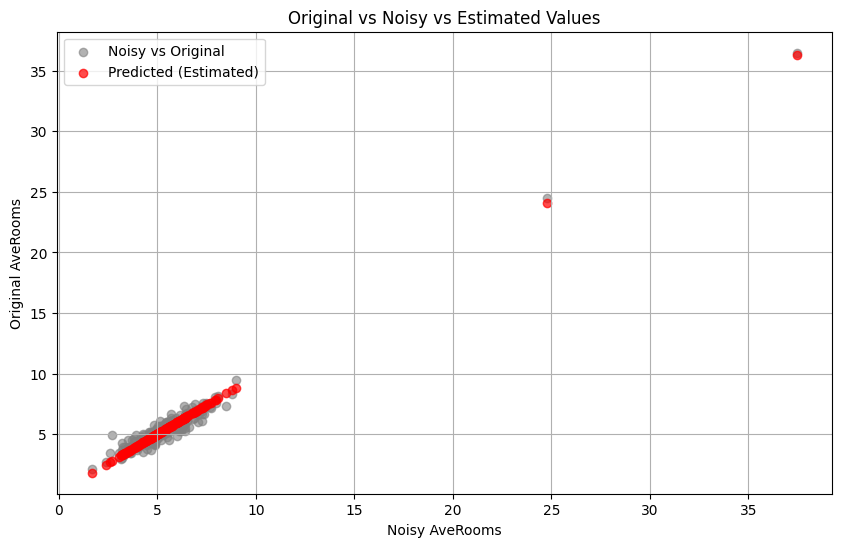

In [602]:
plt.figure(figsize=(10,6))
plt.scatter(test_df['AveRooms_noisy'], test_df['AveRooms'], color='gray', alpha=0.6, label='Noisy vs Original')
plt.scatter(test_df['AveRooms_noisy'], y_pred, color='red', alpha=0.7, label='Predicted (Estimated)')
plt.xlabel("Noisy AveRooms")
plt.ylabel("Original AveRooms")
plt.title("Original vs Noisy vs Estimated Values")
plt.legend()
plt.grid(True)
plt.show()

#### **Discussion**

**Bias and Variance:**

The small bias value of negative 0.014 shows that the estimator is nearly unbiased and that on average its predictions are very close to the true values. The Mean Squared Error (MSE) of 0.236 which is the difference between the variance and the squared bias shows that the model performs reasonably well in estimating the original data despite the added noise. The relatively high variance of 8.00 suggests that the estimates fluctuate substantially around the mean prediction. This trade-off implies that while the model’s average predictions are accurate, its individual estimates can vary widely for different samples.

**Impact of Noise:**

In this case, the addition of a Gaussian noise simulates real world errors like sensor errors.
In real world scenarios data is rarely perfect and the presence of noise reduces the signal-to-noise ratio (SNR), making the relationships harder to detect. resulting in the estimates from the linear regression model becoming less stable and more dispersed. This experiment highlights the importance of data integrity as noise increases, predictive accuracy and reliability decrease.

**Model Limitations:**

linear regression is simple because it assumes a linear relationship between the noisy and the original data. In real world scenarios, a linear assumption may not hold due to non linear relationships. Additionally the linear model is also sensitive to outliers. In scenarios where the relationship between observed data and true values is non linear, a more flexible model such as a polynomial regression would be required. However, choosing a more complex model requires balancing interpretability, computational cost, and the risk of overfitting, especially when working with noisy data.